In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import tensorflow as tf

In [3]:
def load_img(img_dir, img_list):
  images=[]
  for i, image_name in enumerate(img_list):
    if (image_name.split('.')[1] == 'npy'):
      image = np.load(img_dir+image_name)
      images.append(image)
  images = np.array(images)
  return (images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  L = len(img_list)
  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < L:
      limit = min(batch_end, L)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])
      yield (X,Y)
      batch_start += batch_size
      batch_end += batch_size

In [4]:
train_img_dir = "C:/Users/Chirag/Downloads/brats2020_preprocessed/images/"
train_mask_dir = "C:/Users/Chirag/Downloads/brats2020_preprocessed/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
img, mask = train_img_datagen.__next__()

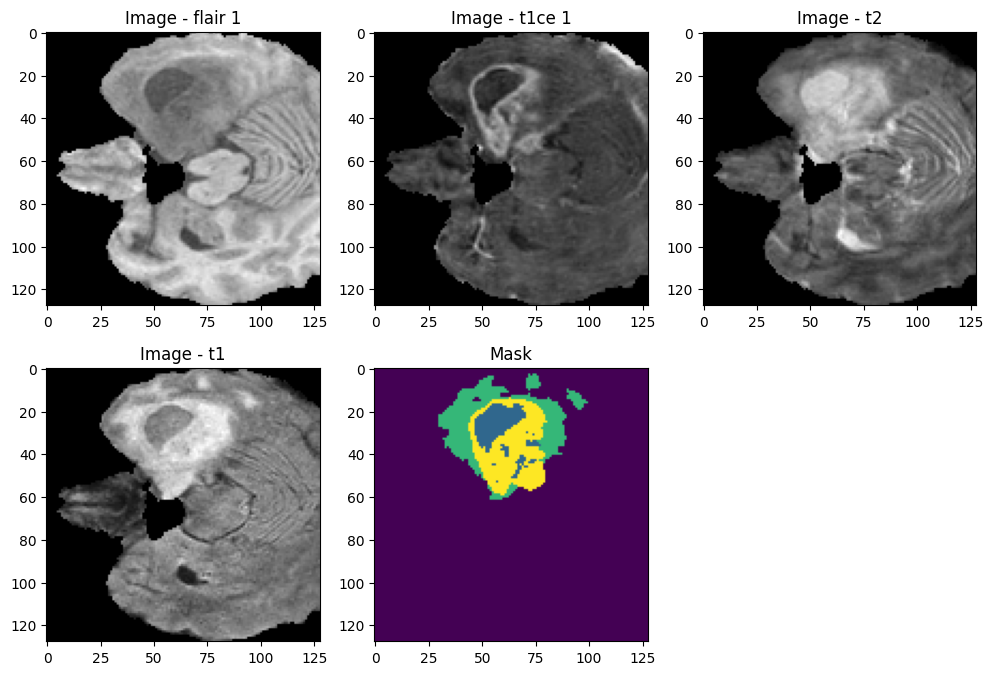

In [14]:
img_num = random.randint(0, img.shape[0]-1)
test_img = img[img_num]
test_mask = mask[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_img.shape[2]-1)
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image - flair 1')

plt.subplot(232)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image - t1ce 1')

plt.subplot(233)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image - t2')

plt.subplot(234)
plt.imshow(test_img[:, :, n_slice, 3], cmap='gray')
plt.title('Image - t1')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

In [15]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda

kernel_initializer =  'he_uniform'

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [16]:
model = simple_unet_model(128, 128, 128, 4, 4)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=[iou_score, dice_score, 'accuracy']
)

In [17]:
batch_size = 2
steps_per_epoch = len(train_img_list) // batch_size
epochs = 20

In [14]:
for i in range(3):
    img_path = os.path.join(train_img_dir, train_img_list[i])
    mask_path = os.path.join(train_mask_dir, train_mask_list[i])

    img = np.load(img_path)
    mask = np.load(mask_path)

    print(f"File {i}: Image shape: {img.shape}, Mask shape: {mask.shape}")

valid_pairs = []
for img_file, mask_file in zip(train_img_list, train_mask_list):
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)

    img = np.load(img_path)
    mask = np.load(mask_path)

    if img.shape == (128, 128, 128, 4) and mask.shape == (128, 128, 128, 4):
        valid_pairs.append((img_file, mask_file))

print(f"Found {len(valid_pairs)} valid 128x128x128 pairs")

train_img_list = [pair[0] for pair in valid_pairs]
train_mask_list = [pair[1] for pair in valid_pairs]

File 0: Image shape: (128, 128, 128, 4), Mask shape: (128, 128, 128, 4)
File 1: Image shape: (128, 128, 128, 4), Mask shape: (128, 128, 128, 4)
File 2: Image shape: (128, 128, 128, 4), Mask shape: (128, 128, 128, 4)
Found 343 valid 128x128x128 pairs


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

callbacks = [
    EarlyStopping(monitor='dice_score', patience=5, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='dice_score', factor=0.5, patience=3, mode='max'),
    ModelCheckpoint('best_model.h5', monitor='dice_score', save_best_only=True, mode='max')
]

history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9314 - dice_score: 0.8397 - iou_score: 0.7375 - loss: 0.3504 

171/171 ━━━━━━━━━━━━━━━━━━━━ 2520s 15s/step - accuracy: 0.9457 - dice_score: 0.8859 - iou_score: 0.8007 - loss: 0.2595 - learning_rate: 1.0000e-04
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9559 - dice_score: 0.9215 - iou_score: 0.8574 - loss: 0.1651

171/171 ━━━━━━━━━━━━━━━━━━━━ 1553s 9s/step - accuracy: 0.9533 - dice_score: 0.9193 - iou_score: 0.8528 - loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9586 - dice_score: 0.9248 - iou_score: 0.8623 - loss: 0.1596

171/171 ━━━━━━━━━━━━━━━━━━━━ 1354s 8s/step - accuracy: 0.9555 - dice_score: 0.9200 - iou_score: 0.8544 - loss: 0.1758 - learning_rate: 1.0000e-04
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9595 - dice_score: 0.9300 - iou_score: 0.8708 - loss: 0.1542

171/171 ━━━━━━━━━━━━━━━━━━━━ 1324s 8s/step - accuracy: 0.9568 - dice_score: 0.9247 - iou_score: 0.8618 - loss: 0.1658 - learning_rate: 1.0000e-04
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9596 - dice_score: 0.9324 - iou_score: 0.8749 - loss: 0.1520

171/171 ━━━━━━━━━━━━━━━━━━━━ 1301s 8s/step - accuracy: 0.9575 - dice_score: 0.9274 - iou_score: 0.8664 - loss: 0.1596 - learning_rate: 1.0000e-04
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9596 - dice_score: 0.9340 - iou_score: 0.8776 - loss: 0.1515

171/171 ━━━━━━━━━━━━━━━━━━━━ 1300s 8s/step - accuracy: 0.9582 - dice_score: 0.9300 - iou_score: 0.8707 - loss: 0.1539 - learning_rate: 1.0000e-04
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9600 - dice_score: 0.9361 - iou_score: 0.8811 - loss: 0.1485

171/171 ━━━━━━━━━━━━━━━━━━━━ 1374s 8s/step - accuracy: 0.9590 - dice_score: 0.9328 - iou_score: 0.8755 - loss: 0.1469 - learning_rate: 1.0000e-04
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9596 - dice_score: 0.9363 - iou_score: 0.8814 - loss: 0.1494 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1773s 10s/step - accuracy: 0.9592 - dice_score: 0.9343 - iou_score: 0.8781 - loss: 0.1431 - learning_rate: 1.0000e-04
Epoch 9/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9600 - dice_score: 0.9377 - iou_score: 0.8837 - loss: 0.1460

171/171 ━━━━━━━━━━━━━━━━━━━━ 1687s 10s/step - accuracy: 0.9597 - dice_score: 0.9363 - iou_score: 0.8814 - loss: 0.1375 - learning_rate: 1.0000e-04
Epoch 10/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9621 - dice_score: 0.9414 - iou_score: 0.8902 - loss: 0.1410

171/171 ━━━━━━━━━━━━━━━━━━━━ 1689s 10s/step - accuracy: 0.9616 - dice_score: 0.9397 - iou_score: 0.8871 - loss: 0.1306 - learning_rate: 1.0000e-04
Epoch 11/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9619 - dice_score: 0.9423 - iou_score: 0.8917 - loss: 0.1373

171/171 ━━━━━━━━━━━━━━━━━━━━ 1694s 10s/step - accuracy: 0.9627 - dice_score: 0.9427 - iou_score: 0.8925 - loss: 0.1233 - learning_rate: 1.0000e-04
Epoch 12/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9621 - dice_score: 0.9430 - iou_score: 0.8931 - loss: 0.1331 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1713s 10s/step - accuracy: 0.9637 - dice_score: 0.9446 - iou_score: 0.8958 - loss: 0.1184 - learning_rate: 1.0000e-04
Epoch 13/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9629 - dice_score: 0.9449 - iou_score: 0.8965 - loss: 0.1277

171/171 ━━━━━━━━━━━━━━━━━━━━ 1591s 9s/step - accuracy: 0.9640 - dice_score: 0.9448 - iou_score: 0.8962 - loss: 0.1181 - learning_rate: 1.0000e-04
Epoch 14/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9626 - dice_score: 0.9439 - iou_score: 0.8947 - loss: 0.1285 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1785s 10s/step - accuracy: 0.9638 - dice_score: 0.9448 - iou_score: 0.8962 - loss: 0.1163 - learning_rate: 1.0000e-04
Epoch 15/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9632 - dice_score: 0.9463 - iou_score: 0.8990 - loss: 0.1246

171/171 ━━━━━━━━━━━━━━━━━━━━ 1530s 9s/step - accuracy: 0.9651 - dice_score: 0.9476 - iou_score: 0.9011 - loss: 0.1102 - learning_rate: 1.0000e-04
Epoch 16/20
  7/171 ━━━━━━━━━━━━━━━━━━━━ 22:28 8s/step - accuracy: 0.9570 - dice_score: 0.9468 - iou_score: 0.8990 - loss: 0.1187

In [5]:
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model.h5')

print(loaded_model.summary())
print("Model loaded successfully!")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,646,262 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Model loaded successfully!


3D volumes shape - Images: (2, 128, 128, 128, 4), Masks: (2, 128, 128, 128, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


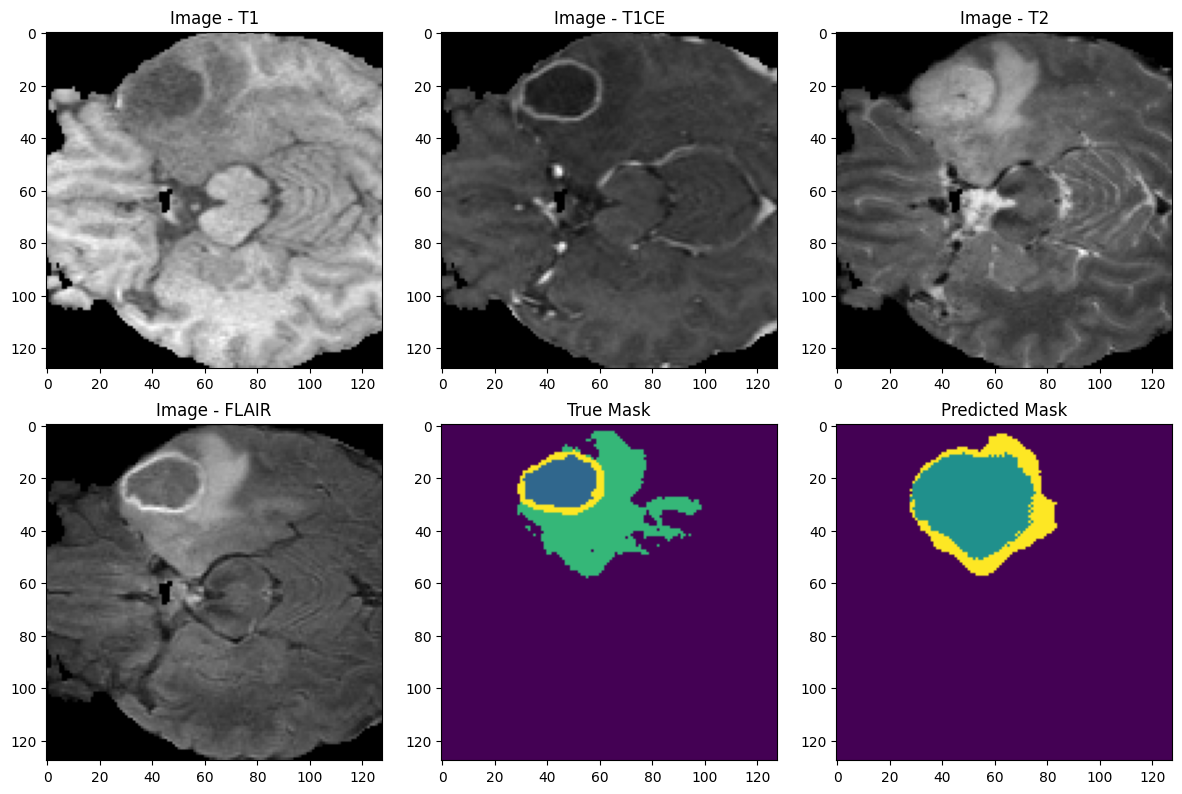

True mask unique values: [0 1 2 3]
Predicted mask unique values: [0 1 2]
Image shape: (128, 128, 128, 4)
Prediction shape: (128, 128, 128)

Overall IoU: 0.920
Overall Dice: 0.958
Tumor IoU: 0.833
Tumor Dice: 0.909


In [18]:
from matplotlib import pyplot as plt
import random

# Load a fresh batch of 3D volumes for prediction
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
img_3d, mask_3d = train_img_datagen.__next__()

print(f"3D volumes shape - Images: {img_3d.shape}, Masks: {mask_3d.shape}")

# Making predictions on 3D volumes
pred = loaded_model.predict(img_3d)
pred_mask = np.argmax(pred, axis=-1)

# Select a random volume and slice for visualization
img_num = random.randint(0, img_3d.shape[0]-1)
test_img = img_3d[img_num]
test_mask = mask_3d[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_img.shape[2]-1)
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image - T1')

plt.subplot(232)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image - T1CE')

plt.subplot(233)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image - T2')

plt.subplot(234)
plt.imshow(test_img[:, :, n_slice, 3], cmap='gray')
plt.title('Image - FLAIR')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('True Mask')

plt.subplot(236)
plt.imshow(pred_mask[img_num][:, :, n_slice])
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()

print(f"True mask unique values: {np.unique(test_mask[:, :, n_slice])}")
print(f"Predicted mask unique values: {np.unique(pred_mask[img_num][:, :, n_slice])}")
print(f"Image shape: {test_img.shape}")
print(f"Prediction shape: {pred_mask[img_num].shape}")

# Calculate IoU and Dice scores
def calculate_metrics(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / (union + 1e-7) if union > 0 else 0.0
    dice = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)
    return iou, dice

true_flat = test_mask[:, :, n_slice].flatten()
pred_flat = pred_mask[img_num][:, :, n_slice].flatten()
overall_iou, overall_dice = calculate_metrics(true_flat == pred_flat, np.ones_like(true_flat))

print(f"\nOverall IoU: {overall_iou:.3f}")
print(f"Overall Dice: {overall_dice:.3f}")

# Tumor detection (any non-background)
true_tumor = (test_mask[:, :, n_slice] > 0).astype(float)
pred_tumor = (pred_mask[img_num][:, :, n_slice] > 0).astype(float)
tumor_iou, tumor_dice = calculate_metrics(true_tumor, pred_tumor)

print(f"Tumor IoU: {tumor_iou:.3f}")
print(f"Tumor Dice: {tumor_dice:.3f}")